In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# Minist

In [3]:
import keras
import numpy as np
keras.__version__

Using TensorFlow backend.


'2.2.4'

## Dataset

In [4]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

### Visualize a sample of Training Data 

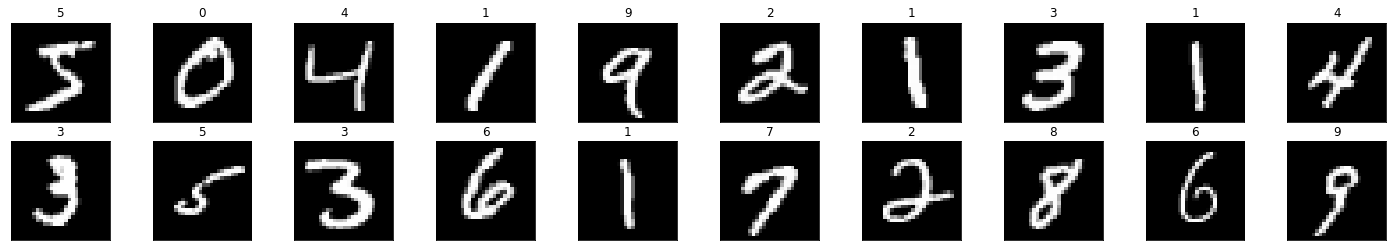

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
images, labels = train_images[:20], train_labels[:20]


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(np.argmax(labels[idx])))

### View an Image in More Detail 

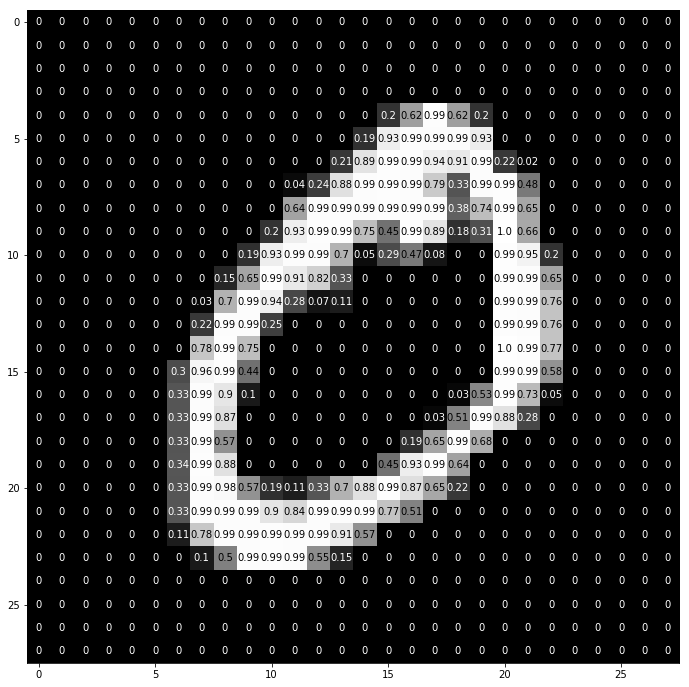

In [6]:
img = np.squeeze(train_images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Define the Network Architecture

The 6 lines of code below show you what a basic convnet looks like. It's a stack of Conv2D and MaxPooling2D layers. We'll see in a minute what they do concretely. Importantly, a convnet takes as input tensors of shape (image_height, image_width, image_channels) (not including the batch dimension). In our case, we will configure our convnet to process inputs of size (28, 28, 1), which is the format of MNIST images. We do this via passing the argument input_shape=(28, 28, 1) to our first layer.

In [7]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

W0909 12:36:42.709567 139786352813888 deprecation_wrapper.py:119] From /home/khan74/.conda/envs/tutorial/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0909 12:36:42.711758 139786352813888 deprecation_wrapper.py:119] From /home/khan74/.conda/envs/tutorial/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 12:36:42.714969 139786352813888 deprecation_wrapper.py:119] From /home/khan74/.conda/envs/tutorial/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0909 12:36:42.728338 139786352813888 deprecation_wrapper.py:119] From /home/khan74/.conda/envs/tutorial/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. P

Let's display the architecture of our convnet so far:

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see above that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to the Conv2D layers (e.g. 32 or 64).

The next step would be to feed our last output tensor (of shape (3, 3, 64)) into a densely-connected classifier network like those you are already familiar with: a stack of Dense layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. So first, we will have to flatten our 3D outputs to 1D, and then add a few Dense layers on top:

In [9]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network looks like:

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

As you can see, our (3, 3, 64) outputs were flattened into vectors of shape (576,), before going through two Dense layers.

Now, let's train our convnet on the MNIST digits. 

## Compile and Train

In [11]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0909 12:36:42.930908 139786352813888 deprecation_wrapper.py:119] From /home/khan74/.conda/envs/tutorial/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0909 12:36:42.941229 139786352813888 deprecation_wrapper.py:119] From /home/khan74/.conda/envs/tutorial/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



The steps for training/learning from a batch of data are described in the comments below:

1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

Keras wraps up all of these steps in one function: `model.fit()`. In the following we train for 5 epochs with a batch size of 64. Notice how the loss decreases and accuracy increases as we train.

In [12]:
model.fit(train_images, train_labels, epochs=5, batch_size=64)

W0909 12:36:44.084557 139786352813888 deprecation.py:323] From /home/khan74/.conda/envs/tutorial/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0909 12:36:44.202870 139786352813888 deprecation_wrapper.py:119] From /home/khan74/.conda/envs/tutorial/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/5
60000/60000 [==============================] - 7s 121us/step - loss: 0.5984 - acc: 0.8515
Epoch 2/5
60000/60000 [==============================] - 6s 105us/step - loss: 0.1613 - acc: 0.9522
Epoch 3/5
60000/60000 [==============================] - 6s 103us/step - loss: 0.1098 - acc: 0.9667
Epoch 4/5
60000/60000 [==============================] - 6s 103us/step - loss: 0.0864 - acc: 0.9743
Epoch 5/5
60000/60000 [==============================] - 6s 103us/step - loss: 0.0729 - acc: 0.9772


## Test the Trained Network

Finally, we test our trained model on previously unseen test data and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [13]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 81us/step


In [14]:
print('Test Accuracy: {:.4f} and Test Loss: {:.4f}'.format(test_acc, test_loss))

Test Accuracy: 0.9818 and Test Loss: 0.0587


In [15]:
# initialize lists to monitor test accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

pred = model.predict(test_images, verbose=0)
pred = np.argmax(pred, axis=-1)
labels = np.argmax(test_labels, axis=-1)

for i in range(len(pred)):
    correct = pred[i] == labels[i]
    class_correct[labels[i]] += correct
    class_total[labels[i]] += 1
    
    
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))  

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1128/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 98% (993/1010)
Test Accuracy of     4: 99% (976/982)
Test Accuracy of     5: 98% (875/892)
Test Accuracy of     6: 98% (942/958)
Test Accuracy of     7: 98% (1015/1028)
Test Accuracy of     8: 98% (957/974)
Test Accuracy of     9: 94% (954/1009)

Test Accuracy (Overall): 98% (9818/10000)


Lets see predictions on individual test images. Since `model.predict` expects a batch of images, i.e, a 4-d tensor, we expand the first dimension of the test image before feeding into model.

Text(0.5, 1.0, 'Prediction: 7')

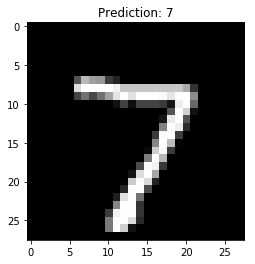

In [16]:
index = 0
pred = model.predict(np.expand_dims(test_images[index], axis=0)); pred = np.argmax(pred)
plt.imshow(np.squeeze(test_images[index]), cmap='gray')
plt.title('Prediction: {}'.format(pred))

In [17]:
#Define a python generator [More on Generators in cifar-10 notebook]
import itertools

def generator(images, labels, batch_size):
    iterable_1 = iter(images)
    iterable_2 = iter(labels)
    while True:
        l1 = tuple(itertools.islice(iterable_1, 0, batch_size))
        l2 = tuple(itertools.islice(iterable_2, 0, batch_size))
        if l1 and l2:
            yield np.vstack(np.expand_dims(l1, axis=0)), np.vstack(np.expand_dims(l2, axis=0))
        else:
            break
            
test_generator = generator(test_images, test_labels, 20)

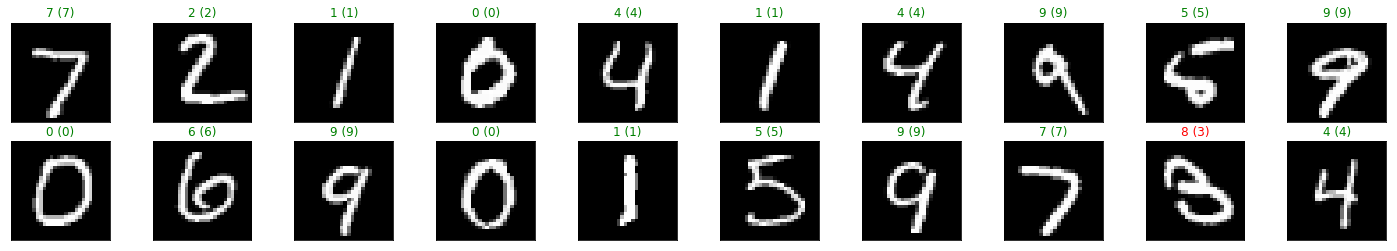

In [18]:
images, labels = next(test_generator)
labels = np.argmax(labels, axis=-1)

# get sample outputs
preds = model.predict(images)
# convert output probabilities to predicted class
preds = np.argmax(preds, axis=-1)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## Interpret

### Visualizing second-last-layer Activations

In [19]:
from keras import Model

emb_model = Model(input = model.input, output = model.get_layer('dense_1').output)

/home/khan74/.conda/envs/tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
emb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
__________

In [21]:
activations = emb_model.predict(test_images, verbose=1)
predictions = model.predict(test_images, verbose=1); labels = predictions.argmax(axis=-1)

10000/10000 [==============================] - 1s 56us/step


In [22]:
activations.shape

(10000, 64)

Spectral_r, gnuplot2

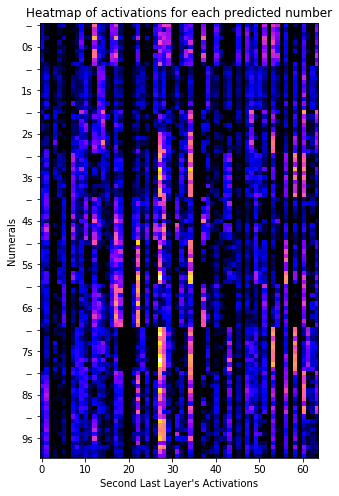

In [23]:
# Stack 10 examples of activation vectors for each numeral
seq = []
for i in range(10):
    seq.append(activations[labels==i][:10])
seq = np.vstack(seq)


# Plot heatmap for the example activations
plt.figure(figsize=(8,8))
plt.imshow(seq, interpolation='nearest', cmap=plt.cm.gnuplot2)
plt.yticks(np.arange(0,100, 5), ['--','0s','--','1s','--','2s','--','3s','--','4s','--','5s','--','6s',
                                 '--','7s','--','8s','--','9s','--'])
plt.xlabel("Second Last Layer's Activations")
plt.ylabel('Numerals')
plt.title('Heatmap of activations for each predicted number')
plt.show()

#### Tensorboard

In [24]:
import io

with io.open('vecs.tsv', 'w', encoding='utf-8') as out_v:
    for embed in activations:
        out_v.write('\t'.join([str(x) for x in embed]) + "\n")
        
with io.open('meta.tsv', 'w', encoding='utf-8') as out_m:
    for l in labels:
        out_m.write(str(l) + "\n")

Now go to: https://projector.tensorflow.org/, in the data section click `Load`, and upload the two files: _vecs.tsv_ and _meta.tsv_

#### tSNE 

In [44]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [47]:
tsne = TSNE(n_components=3, verbose=1).fit_transform(activations)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.021s...
[t-SNE] Computed neighbors for 10000 samples in 7.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.395028
[t-SNE] KL divergence after 10 iterations with early exaggeration: 97.489616
[t-SNE] KL divergence after 1000 iterations: 1.370488


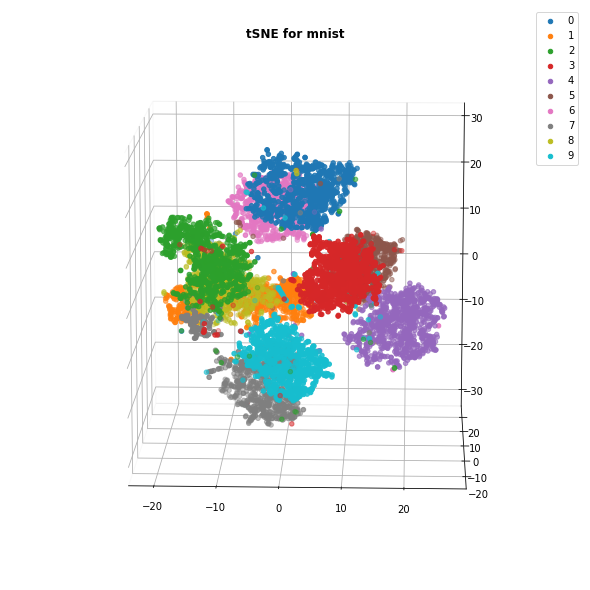

In [57]:
#Plot tSNE

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)

ax.scatter3D(tsne[:,0][labels==0], tsne[:,2][labels==0], tsne[:,1][labels==0], label='0')
ax.scatter3D(tsne[:,0][labels==1], tsne[:,2][labels==1], tsne[:,1][labels==1], label='1')
ax.scatter3D(tsne[:,0][labels==2], tsne[:,2][labels==2], tsne[:,1][labels==2], label='2')
ax.scatter3D(tsne[:,0][labels==3], tsne[:,2][labels==3], tsne[:,1][labels==3], label='3')
ax.scatter3D(tsne[:,0][labels==4], tsne[:,2][labels==4], tsne[:,1][labels==4], label='4')
ax.scatter3D(tsne[:,0][labels==5], tsne[:,2][labels==5], tsne[:,1][labels==5], label='5')
ax.scatter3D(tsne[:,0][labels==6], tsne[:,2][labels==6], tsne[:,1][labels==6], label='6')
ax.scatter3D(tsne[:,0][labels==7], tsne[:,2][labels==7], tsne[:,1][labels==7], label='7')
ax.scatter3D(tsne[:,0][labels==8], tsne[:,2][labels==8], tsne[:,1][labels==8], label='8')
ax.scatter3D(tsne[:,0][labels==9], tsne[:,2][labels==9], tsne[:,1][labels==9], label='9')

ax.legend(loc='upper right')
ax.view_init(elev=12, azim=-88)

font = {'fontname':'Times New Roman'}
plt.title('tSNE for mnist', fontsize=12, fontweight="bold", pad=15, **font)


#Set Ticks
#ax.xaxis.set_major_locator(MultipleLocator(10))
#ax.yaxis.set_major_locator(MultipleLocator(10))
#ax.zaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

### Visualizing intermediate-layer activations

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

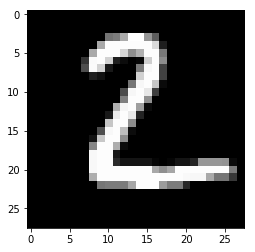

In [26]:
img = test_images[1]
img = np.expand_dims(img, axis=0)

plt.imshow(np.squeeze(img), cmap='gray')

In [27]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [28]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img)

In [29]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 26, 26, 32)


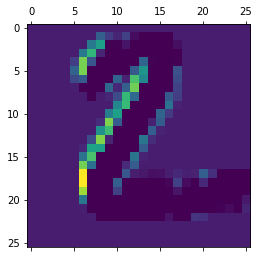

In [30]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
plt.show()

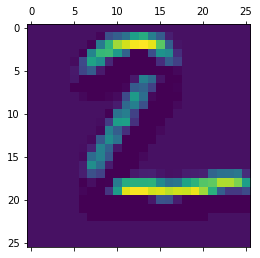

In [31]:
plt.matshow(first_layer_activation[0, :, :, 6], cmap='viridis')
plt.show()

/home/khan74/.conda/envs/tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


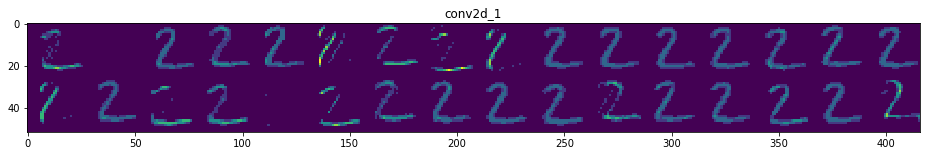

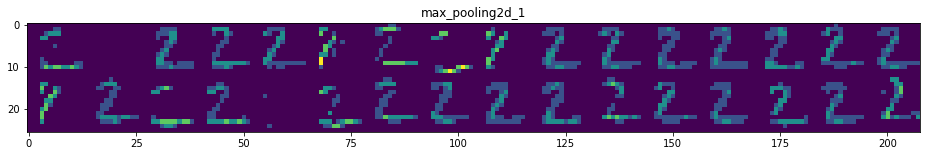

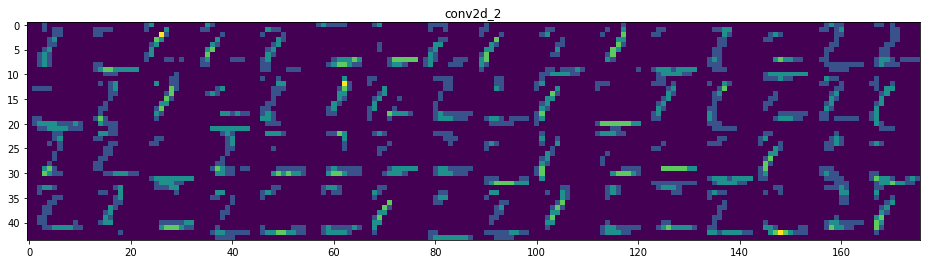

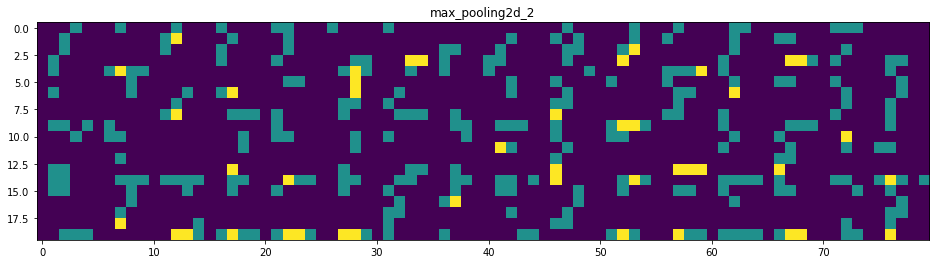

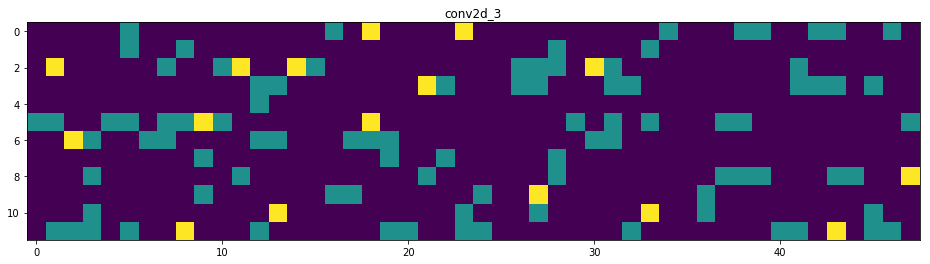

In [32]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:5]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            #channel_image *= 64
            #channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

### Visualizing heatmap of class activation 

To visualize which parts of our image were the most "prediction"-like, let's set up the Grad-CAM process:


In [92]:
import keras.backend as K
import cv2

In [93]:
def get_heatmap(pred):
    # This is the "pred" entry in the prediction vector
    pred_output = model.output[:, pred]

    # The is the output feature map of the `conv2d_3` layer,
    # the last convolutional layer in our model
    last_conv_layer = model.get_layer('conv2d_3')

    # This is the gradient of the "pred" class with regard to
    # the output feature map of `conv2d_3`
    grads = K.gradients(pred_output, last_conv_layer.output)[0]

    # This is a vector of shape (64,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `conv2d_3`,
    # given a sample image
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of pred
    pooled_grads_value, conv_layer_output_value = iterate([img])

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the elephant class
    for i in range(5):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    
    return heatmap

In [94]:
def get_superimposed_img(img, heatmap):
    im = np.array(np.squeeze(img) * 255, dtype = np.uint8)
    cv2.imwrite('test_img.jpg', im)

    # We use cv2 to load the original image
    img = cv2.imread('test_img.jpg', 0)

    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.9 + img

    # Save the image to disk
    cv2.imwrite('test_img_cam.jpg', superimposed_img)
    
    cam = cv2.imread('test_img_cam.jpg', 0)
    return cam, heatmap

In [96]:
img = test_images[10]
img = np.expand_dims(img, axis=0)

pred = model.predict(img)
pred = np.argmax(pred); pred

0

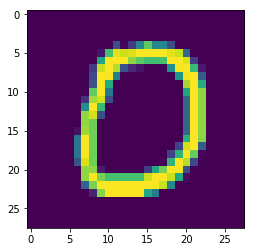

In [97]:
plt.imshow(np.squeeze(img))

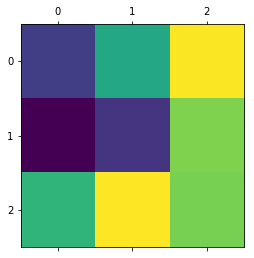

In [98]:
heatmap = get_heatmap(pred)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [99]:
cam, heatmap = get_superimposed_img(img, heatmap)

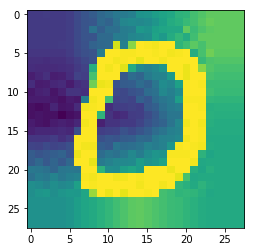

In [100]:
plt.imshow(cam)

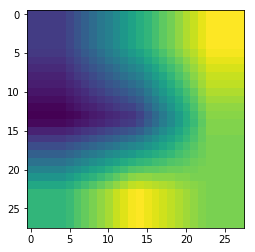

In [101]:
plt.imshow(heatmap)

In [106]:
cams, heatmaps = [], []

for i in range(10):
    
    img = test_images[i]
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    pred = np.argmax(pred); pred
    
    
    heatmap = get_heatmap(pred)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
        
    cam, heatmap = get_superimposed_img(img, heatmap)
    
    cams.append(cam)
    heatmaps.append(heatmap)

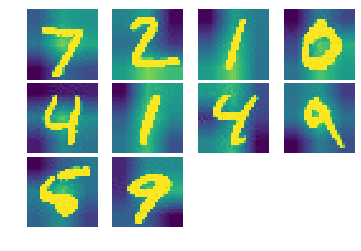

In [107]:
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.axis('Off')
    plt.subplots_adjust(wspace=0.1,hspace=0.05)
    plt.imshow(cams[i])

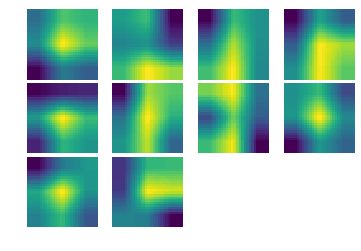

In [108]:
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.axis('Off')
    plt.subplots_adjust(wspace=0.1,hspace=0.05)
    plt.imshow(heatmaps[i])